In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN,LSTM, Dense,Dropout,Conv1D, MaxPooling1D, Bidirectional
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec


In [2]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Suicide_Detection.csv')

In [4]:
# Define a mapping from labels to numbers
label_mapping = {'suicide': 1, 'non-suicide': 0}

# Replace the labels in the 'label' column
df['class'] = df['class'].map(label_mapping)

In [5]:
df=df.dropna()
df.describe()

,Unnamed: 0,class
count,41337.000000,41337.000000
mean,31045.271573,0.497859
std,17901.162606,0.500001
min,2.000000,0.000000
25%,15534.000000,0.000000
50%,31114.000000,0.000000
75%,46572.000000,1.000000
max,61976.000000,1.000000


In [6]:
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,1.0
1,3,Am I weird I don't get affected by compliments...,0.0
2,4,Finally 2020 is almost over... So I can never ...,0.0
3,8,i need helpjust help me im crying so hard,1.0
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",1.0


In [8]:
  # Preprocess the data
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
data = pad_sequences(sequences, maxlen=200)


In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(data, df['class'], test_size=0.2, random_state=1)

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


In [122]:
# Define the model
model = Sequential()
model.add(Embedding(5000, 64, input_length=200))
model.add(Conv1D(256, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.5))  # Dropout layer
model.add(Bidirectional(LSTM(64, dropout=0.4, recurrent_dropout=0, activation='tanh', recurrent_activation='sigmoid')))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))  # L2 regularization)


In [123]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/3
2067/2067 [==============================] - 65s 29ms/step - loss: 0.2568 - accuracy: 0.9047 - val_loss: 0.2026 - val_accuracy: 0.9242
Epoch 2/3
2067/2067 [==============================] - 26s 13ms/step - loss: 0.1797 - accuracy: 0.9363 - val_loss: 0.2040 - val_accuracy: 0.9240
Epoch 3/3
2067/2067 [==============================] - 25s 12ms/step - loss: 0.1547 - accuracy: 0.9472 - val_loss: 0.2037 - val_accuracy: 0.9266


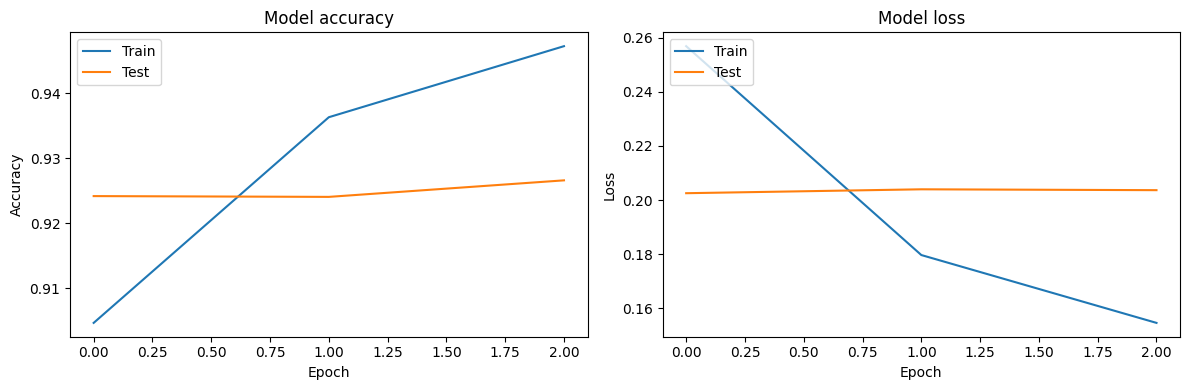

In [124]:
# early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(X_train, y_train, batch_size=16, epochs=3, validation_data=(X_test, y_test))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [125]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %f' % (accuracy*100))

259/259 [==============================] - 1s 5ms/step - loss: 0.2037 - accuracy: 0.9266
Test Accuracy: 92.658442


259/259 [==============================] - 3s 5ms/step


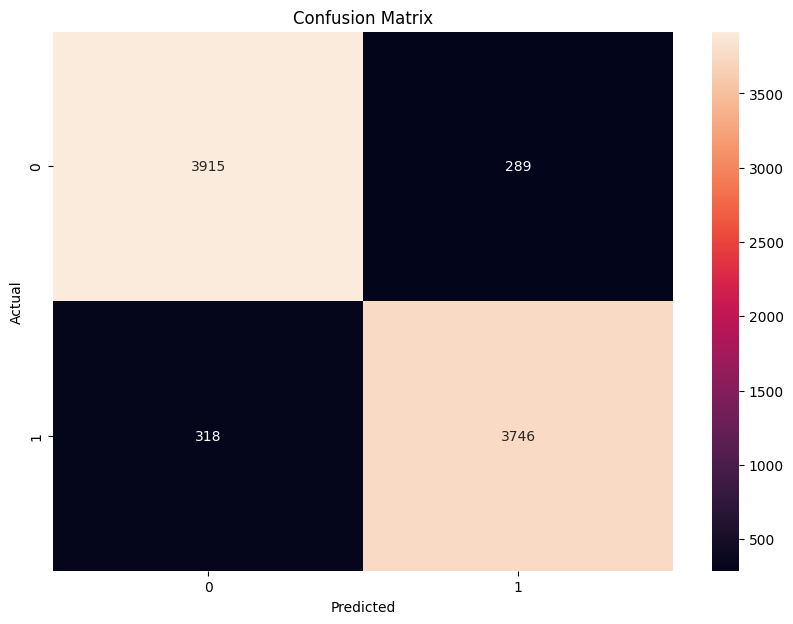

In [126]:
from sklearn.metrics import confusion_matrix
# Get the predicted probabilities
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = (y_pred_prob > 0.5).astype('int32')

# Now you can use y_pred to create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()